In [2]:
%matplotlib inline
import numpy as np
import imageio
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter
from sklearn.cluster import KMeans
from skimage import filters
from skimage import feature
from sklearn.decomposition import NMF
import glob
# import os
# from os import listdir
# from os.path import isfile, join
import matplotlib.pyplot as plt 
from matplotlib import style 
from math import sqrt
from skimage.color import rgb2gray

### Load images from local

In [3]:
mypath_salt ='C:/Users/Tsaip/OneDrive - Imperial College London/Ovation Data Internship 2020/Data/competition_data/competition_data/train/images'
mypath_mask ='C:/Users/Tsaip/OneDrive - Imperial College London/Ovation Data Internship 2020/Data/competition_data/competition_data/train/masks'


f_salt = glob.glob(mypath_salt + "/*.png")
f_mask = glob.glob(mypath_mask + "/*.png")
# Pick random number to check the dimension
im = imageio.imread(f_salt[8])
mask_ = imageio.imread(f_mask[8])

numImg = len(f_salt)
gray_img = rgb2gray(im)
width = gray_img.shape[0]
length = gray_img.shape[1]
print('There are', len(f_salt), ' images. Image shape: ', width, length)
print('The mask has shape', mask_.shape)
print('...Loading traning images to list...')

grayscale_data = np.zeros((len(f_salt), width, length))
mask_data_t = np.zeros((len(f_mask), width*length))
n = 0
for path_f, path_m in zip(f_salt, f_mask):
    im = imageio.imread(path_f)
    grayscale_data[n] = rgb2gray(im) # Turn RGB to gray scale
    tmp = imageio.imread(path_m)/65535 # Turn into binary class. 0 indicate no salt
    mask_data_t[n] = np.reshape(tmp, (width*length,))
    n+= 1
    
print('=== Finished Loading Traning Images ===')
del n, tmp, f_salt, f_mask

There are 4000  images. Image shape:  101 101
The mask has shape (101, 101)
...Loading traning images to list...
=== Finished Loading Traning Images ===


(4000, 10201)
(1862, 101, 101)


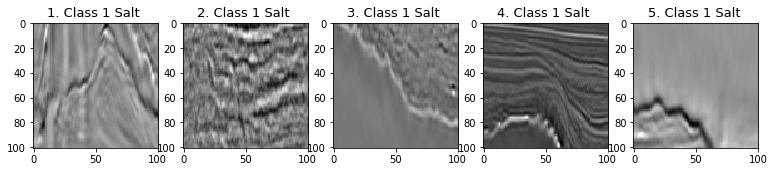

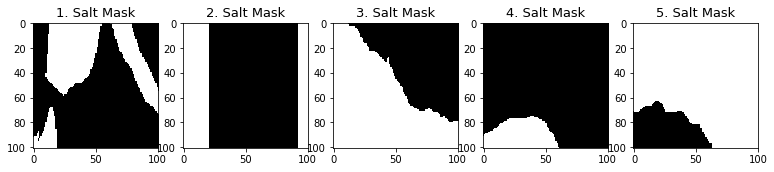

In [4]:
# Show salt coverage. Exclude any salt coverage below 10%
print(mask_data_t.shape)
coverage = np.sum(mask_data_t, axis = 1)/(width*length) # Take the sum of each mask and devided by the image size

mask_data = np.zeros((numImg, width, length))
mask_data = np.reshape(mask_data_t, (numImg, width, length)) # For validate accuracy

salt_data = grayscale_data[coverage > 0.1]
salt_mask = mask_data[coverage > 0.1]
other_data = grayscale_data[coverage <= 0.1]
other_mask = mask_data[coverage <= 0.1]
print(salt_data.shape)
# Plot some images and corresponding mask
fig, axarr = plt.subplots(1, 5, figsize=(13, 13))
for ax, n in zip(axarr.flatten(), np.arange(5)):
    ax.imshow(salt_data[n+555], cmap='gray')
    ax.set_title("%i. " % (n+1) + "Class 1 Salt " , fontsize=13)
plt.show()
fig, axarr = plt.subplots(1, 5, figsize=(13, 13))
for ax, n in zip(axarr.flatten(), np.arange(5)):
    ax.imshow(salt_mask[n+555], cmap='gray')
    ax.set_title("%i. " % (n+1) + "Salt Mask", fontsize=13)
plt.show()
# fig, axarr = plt.subplots(1, 5, figsize=(13, 13))
# for ax, n in zip(axarr.flatten(), np.arange(5)):
#     ax.imshow(other_data[n+5], cmap='gray')
#     ax.set_title("%i. " % (n+1) + "Class 2 Other " , fontsize=13)
# plt.show()
# fig, axarr = plt.subplots(1, 5, figsize=(13, 13))
# for ax, n in zip(axarr.flatten(), np.arange(5)):
#     ax.imshow(other_mask[n+5], cmap='gray')
#     ax.set_title("%i. " % (n+1) + "Other Mask", fontsize=13)
# plt.show()

### Initialise W and H

In [5]:
# def RunNMF(data, numImagesPerClass, wide, length, sparsity)
# data: dataset, numImage:list of number of images per class in order, width, length
data = np.concatenate([salt_data]) #, other_data
numImagesPerClass = [salt_data.shape[0]] #, other_data.shape[0]

numImages = salt_data.shape[0] # total number of processed images here
NumOfClasses = 1

X = np.reshape(data,(numImages, width*length)).T
print('Data matrix X shape: ', X.shape)
# Check if there is negative element in the matrix. The dataset should be normalised to [0, 1]
if (X < 0).any():
    print('Matrix elements are not all positive!')

X_class = []
# split features based on classes
for i in np.arange(NumOfClasses):
    if i!= 0:
        X_class.append(X[:,numImagesPerClass[i-1]:numImagesPerClass[i-1]+numImagesPerClass[i]])
    else:
        X_class.append(X[:,:numImagesPerClass[i]])
    
N_p = len(X)
set_sparsity = 0.4
L1toL2 = sqrt(N_p) - sqrt(N_p-1)*set_sparsity # L1L2ratio



Data matrix X shape:  (10201, 1862)


### Run kmeans

In [93]:
k_clusters = 250
kmeans = []
# Perform kmeans on each dataset features
for i in np.arange(NumOfClasses):
    kmeans.append(KMeans(n_clusters=k_clusters, max_iter=1000).fit(X_class[i].T))

In [94]:
yu = kmeans[0].cluster_centers_.T
yu .shape

(10201, 250)

### set W_init and H_init for NMF input

In [95]:
# def init_WH(width, length, kmeans,NumOfClasses, k_clusters)
# Extract kmeans centres of each class and stack them into W_init
W_init = np.zeros((width*length, NumOfClasses*k_clusters))
for i in np.arange(NumOfClasses):
    W_init[:, i*k_clusters:(i+1)*k_clusters] = kmeans[i].cluster_centers_.T
np.random.seed(20)
H_init = np.random.uniform(0.0, 1.0, size = (NumOfClasses*k_clusters, numImages))

# Make sure all the centroids are nonnegative
W_init[W_init<0.001] = 0

In [96]:
# Used kmeans centroid as W and H initialisation. Use nmf package for updating W and H.
n_components = NumOfClasses*k_clusters
modelTest1 = NMF(n_components= n_components, init='custom', solver='mu', 
                 beta_loss='frobenius', tol=0.0001, max_iter=500, 
                 random_state=None, alpha=0.1)

W_all = modelTest1.fit_transform(X, W = W_init, H = H_init)
H_all = modelTest1.components_

In [141]:
'''Nonnegative Double Singular Value Decomposition (NNDSVD)
            initialization (better for sparseness)
            NNDSVD with zeros filled with small random values
            (generally faster, less accurate alternative to NNDSVDa
            for when sparsity is not desired)'''
# Individual class nmf
NMFmodel = []
W_class = []# np.zeros((NumOfClasses, width*length, k_clusters))
H_class = []# np.zeros((NumOfClasses, k_clusters, numImages))

for i in np.arange(NumOfClasses):
    NMFmodel.append(NMF(n_components=k_clusters,init='random', solver='mu', 
                        beta_loss='frobenius', tol=0.0001, max_iter=500, 
                        random_state=None, alpha=0))
    
    W_class.append(NMFmodel[i].fit_transform(X_class[i]))
    H_class.append(NMFmodel[i].components_)

C:\Users\Tsaip\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


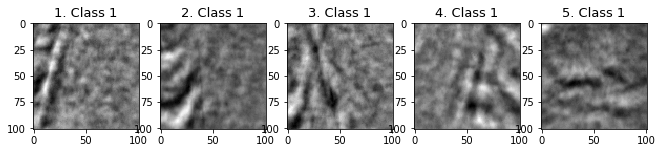

In [208]:
WH_product = np.dot(W_class[0], H_class[0])
# WH_product = np.dot(W_all, H_all)
img_nmf_all = np.reshape(WH_product.T, (numImagesPerClass[0],width,length))
for i in np.arange(1):
    fig, axarr = plt.subplots(1, 5, figsize=(11, 11))
    for ax, n in zip(axarr.flatten(), np.arange(5)):
        ax.imshow(img_nmf_all[n+455], cmap='gray')
        ax.set_title("%i. " % (n+1) + "Class %i"  % (i+1), fontsize=13)
    plt.show()


### concatenate W and H respectively 
### Stacked process option 1: stack single class nmf result together

In [99]:
W_conc = np.zeros((width*length, k_clusters*NumOfClasses))
H_conc = np.zeros((k_clusters*NumOfClasses, numImages))

for i in np.arange(NumOfClasses):
    if i!=0:
        cur_idx = numImagesPerClass[i-1]
        next_idx = cur_idx + numImagesPerClass[i]
    else:# i==0
        cur_idx = 0
        next_idx = numImagesPerClass[i]
    H_conc[i*k_clusters:(i+1)*k_clusters, cur_idx:next_idx] = H_class[i]
    W_conc[:, i*k_clusters:(i+1)*k_clusters] = W_class[i]
# H_conc[0:250, 2017:]

### Stacked process option 2: stack single class nmf H on whole dataset nmf H

In [100]:
# combine single class of H result onto all class result H
# Concatenate W and H to to facilitate stacked calculation
H_concat = H_all
for i in np.arange(NumOfClasses):
    if i!=0:
        cur_idx = numImagesPerClass[i-1]
        next_idx = cur_idx + numImagesPerClass[i]
    else:# i==0
        cur_idx = 0
        next_idx = numImagesPerClass[i]
    H_concat[i*k_clusters:(i+1)*k_clusters, cur_idx:next_idx] = H_class[i]

In [43]:
ii=H_concat[k_clusters:2*k_clusters, :numImagesPerClass[0]]
H_concat.shape

(800, 4000)

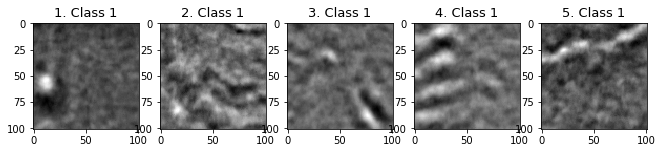

In [106]:
WH_product = np.dot(W_conc, H_conc)
# WH_product = np.dot(W_all, H_all)
img_nmf_all = np.reshape(WH_product.T, (numImages,width,length))
for i in np.arange(NumOfClasses):
    fig, axarr = plt.subplots(1, 5, figsize=(11, 11))
    for ax, n in zip(axarr.flatten(), np.arange(5)):
        if i!=0:
            idx = n+numImagesPerClass[i-1]
        else:
            idx = n
        ax.imshow(img_nmf_all[idx+5], cmap='gray')
        ax.set_title("%i. " % (n+1) + "Class %i"  % (i+1), fontsize=13)
    plt.show()
if NumOfClass!=1: 
    # clear memory
    
else:
    cannyDetection()
    
del WH_product

In [214]:
# Use cannyedge or sobel to extract the feature line.
edge = np.zeros((numImages, width,length))
dilate = np.zeros((numImages, width,length))
for n in np.arange(numImages):# img_nmf_all
    edge[n] = feature.canny(img_nmf_all[n], sigma = 1, low_threshold=0.25,high_threshold=0)
    for i in np.arange(5):
        dilate[n]= ndimage.morphology.binary_dilation(edge[n])

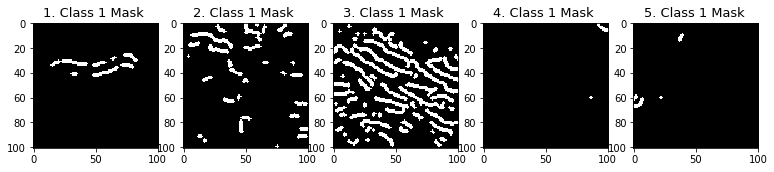

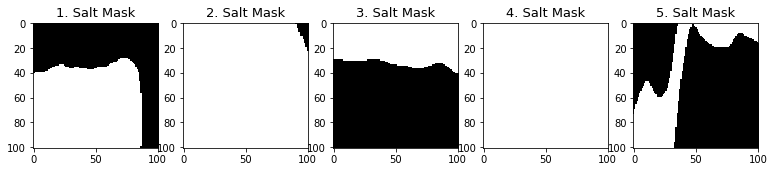

In [218]:
fig, axarr = plt.subplots(1, 5, figsize=(13, 13))
for ax, n in zip(axarr.flatten(), np.arange(5)):
    ax.imshow(salt_data[n+232])
    ax.imshow(dilate[n+232], cmap='gray', alpha = 1)
    ax.set_title("%i. " % (n+1) + "Class 1 Mask " , fontsize=13)
plt.show()
fig, axarr = plt.subplots(1, 5, figsize=(13, 13))
for ax, n in zip(axarr.flatten(), np.arange(5)):
    ax.imshow(salt_mask[n+232], cmap='gray')
    ax.set_title("%i. " % (n+1) + "Salt Mask", fontsize=13)
plt.show()

In [101]:
def plotHistogram_W(W_, name_):
    '''
    Plot Histogram of basis matrix.
    The histogram indicates disdributions of each geophysical feature magnitude.
    
    W_ : numpy array of basis matrix W
    name_: numpy array of string
    eg.     W_ = np.array([W1, W2])
            name_ = np.array([name1, name2])
    
    '''
    f, axs = plt.subplots(1,2, figsize=(15,3))
    im = np.arange(2) # Plot distribution of two W
    
    for n, W, name in zip(im, W_, name_):
        w = np.zeros((NumOfClasses, W.shape[0]*k_clusters))
        W_flat = np.reshape(W, (W.shape[0]*W.shape[1],))
        for i in np.arange(NumOfClasses):
#             Assign classes of w into w[i] for plotting
            w[i] = W_flat[W.shape[0]*k_clusters*i : W.shape[0]*k_clusters*(i+1)]

            # You can normalize it by setting 
            # density=True and stacked=True. By doing this the total area under each distribution becomes 1.
            # e.g: dict(density=True, stacked=True)
            kwargs = dict(alpha=0.35) # Set opacity

            axs[n].hist(w[i], **kwargs, label= 'Class %i'%(i+1) )
            
        axs[n].set_title('Frequency Histogram of '+ name)
        axs[n].set_xlabel('Seismic Feature Magnitude',fontsize=14)
        axs[n].set_ylabel('Frequency',fontsize=14)
        axs[n].legend(prop={'size': 14})
    plt.show()
    print('The above histogram shows distibution of features in two different basis matrices W')
    f.savefig('W_Histograms.jpg')
    return 

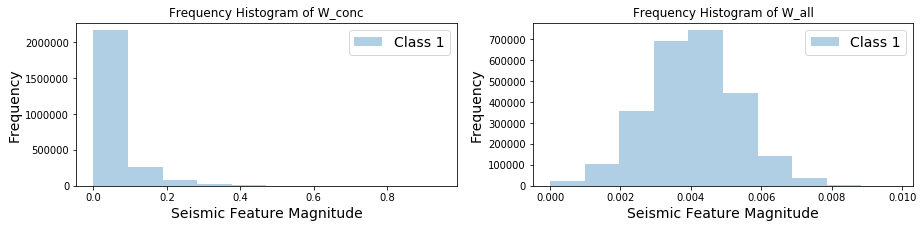

The above histogram shows distibution of features in two different basis matrices W


In [102]:
W_ = np.array([W_conc, W_all])
name_ = np.array(['W_conc', 'W_all'])
plotHistogram_W(W_,name_)

### 来改改这个！

In [6]:
y1 = H_concat[0:k, n-1]
y2 = H_s[:, n-1500+ii-1]
# def plotH(numPlot, )
#     f, axs = plt.subplots(1,numPlot, figsize=(17,3))
#     for ii in range(numPlot):
#         y1 = H_concat[0:k, n-1]
#         y2 = H_s[:, n-1500+ii-1]
#         lg1, = axs[ii].plot(x, y1, 'bx', label='Stacked H')
#         lg2, = axs[ii].plot(x, y2,'r.', label = 'Single H')
#         axs[ii].set_xlabel("Index of feature")
#         axs[ii].set_ylabel("Magnitude")
#         axs[ii].set_title("No.%i. Salt feature coeeficient."%(n+ii),fontsize=11)
#         axs[ii].legend(handles=[lg1, lg2], loc = 'upper right',fontsize=11)
#     f.savefig('H .jpg')
#     return

NameError: name 'H_concat' is not defined

### Normalised columns of binary classification matrix

In [103]:
def normalizeColumns(matrix):
# normalizes the input matrix to have the L1 norm of each column = 1
    output = np.zeros((matrix.shape))
    for i in range(matrix.shape[1]):
        output[:,i] = np.divide(matrix[:,i], sum(abs(matrix[:,i])))
    return output

In [113]:
Qr = np.kron(np.eye(NumOfClasses, NumOfClasses), np.ones((k_clusters,1)))
Qr = normalizeColumns(Qr)
Y = np.zeros((numImages, width*length, NumOfClasses))
N_class = np.ones((1,NumOfClasses))

for img in range(0, numImages):
    Hi = np.reshape(H_conc[:,img],(len(H_conc[:,img]),1))
    # map the coefficients of each image into the seismic structures that make up that image
    # Each Y shows the likelihood of each seismic structure for each pixel in the image.
    H_class = np.dot(Hi,N_class)
    WH_i = np.dot(W_conc, np.multiply(Qr, H_class))
#     print('len(WH_product)',len(WH_product))
    Y[img,:, :] = WH_i

### Filter the labeled matrix Y and find the most confident areas in each image

In [105]:
background = False # Choose if the label includes 'background', background indicates no traps
if background:
    bkgrd_label = NumOfClasses+1 
else:
    bkgrd_label = NumOfClasses-1

In [68]:
bkgrd_label

1

In [107]:
gaussian_filtering = True
median_filtering = True
sigma = 0.8 # 0.4

if gaussian_filtering:
#     Filter each image
    for n in np.arange(numImages):
        Y_n = np.zeros((width,length))
        Y_n = Y[n, :, :]
        for label in range(NumOfClasses):
            temp = np.reshape(Y_n[: ,label].T,(width,length))
            temp = gaussian_filter(temp, sigma)
            Y[n, :,label] = np.reshape(temp,(length*width,))


# Get the maximun value of each row 
vals= np.max(Y,axis = 2)
#  Using vals to show which area has more confidence
# devided by sum of each row
conf = np.divide(vals, np.sum(Y,axis = 2)+1e-5)
# Get the column index of maximum value. The index indicate which class the pixel falls in.
classImg = np.argmax(Y,axis = 2)

classified_all = np.zeros((numImages, width, length))
if median_filtering:
    #     Filter each image
    for n in np.arange(numImages):
        img = np.reshape(classImg[n], (length, width))
        classified_all[n] = median_filter(img,size = (3,3), mode = 'reflect')

# Turn all the low confidence pixels to other class, class 5
std = np.std(conf, axis = 1)
threshold = np.mean(conf, axis = 1)+std/3.1 # 3.1 can be tuned

# Turn all the low confidence pixels to other class, class 5
# Reshape confidence values into data matrix's dimension
conf = np.reshape(conf, (numImages, length, width))
print('conf shape:', conf.shape)
# loop through all the images to get the classification mask
for n in np.arange(numImages):
    classified_all[n][conf[n]<threshold[n]] = bkgrd_label # label 1 means 'other' class in our case


conf shape: (1862, 101, 101)


In [108]:
# output coordination of feature pixel
classN = []
for i in np.arange(NumOfClasses):
    classN.append(np.where(classified_all==i))
if background:
    classN.append(np.where(classified_all==bkgrd_label))


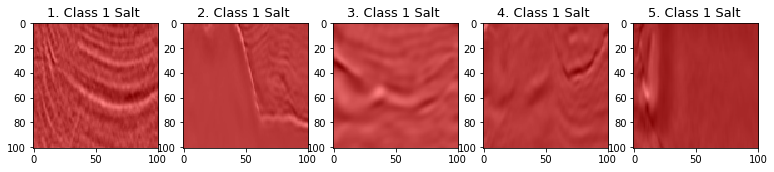

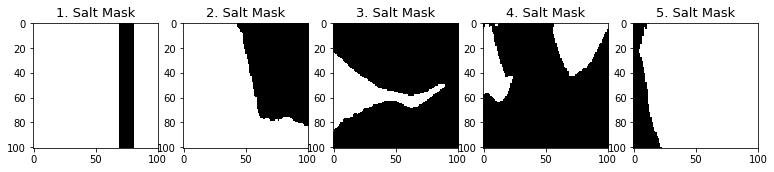

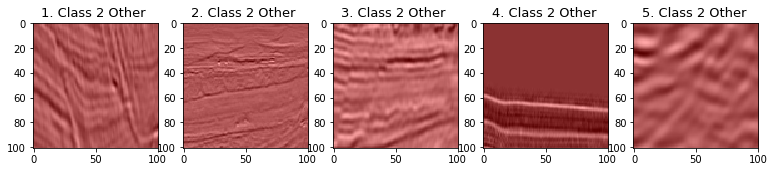

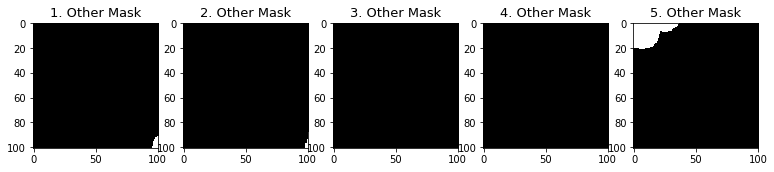

In [111]:
temp1 = np.zeros((numImages, width, length, 3)) # 3 channels
color_img = np.uint8(temp1)
color_img[classN[0][0], classN[0][1], classN[0][2], :] = [255,0,0] # red salt
# color_img[classN[1][0], classN[1][1], classN[1][2], :] = [183,183,183] # grey other

# Plot
fig, axarr = plt.subplots(1, 5, figsize=(13, 13))
for ax, n in zip(axarr.flatten(), np.arange(5)):
    ax.imshow(salt_data[n+1], cmap='gray')
    ax.imshow(color_img[n+1], alpha=.5)
    ax.set_title("%i. " % (n+1) + "Class 1 Salt " , fontsize=13)
plt.show()
fig, axarr = plt.subplots(1, 5, figsize=(13, 13))
for ax, n in zip(axarr.flatten(), np.arange(5)):
    ax.imshow(salt_mask[n+1], cmap='gray')
    ax.set_title("%i. " % (n+1) + "Salt Mask", fontsize=13)
plt.show()
fig, axarr = plt.subplots(1, 5, figsize=(13, 13))
for ax, n in zip(axarr.flatten(), np.arange(5)):
    ax.imshow(other_data[n+5], cmap='gray')
    ax.imshow(color_img[n+5], alpha=.35)
    ax.set_title("%i. " % (n+1) + "Class 2 Other " , fontsize=13)
plt.show()
fig, axarr = plt.subplots(1, 5, figsize=(13, 13))
for ax, n in zip(axarr.flatten(), np.arange(5)):
    ax.imshow(other_mask[n+5], cmap='gray')
    ax.set_title("%i. " % (n+1) + "Other Mask", fontsize=13)
plt.show()

In [90]:
color_img[classN[0][0], classN[0][1], classN[0][2]] == [255,0,0]
classN[1][0]



array([   0,    0,    0, ..., 3999, 3999, 3999], dtype=int64)